In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
import h5py
import multigrate

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = 'retina'

# Load the datasets

In [4]:
scrna = sc.read_h5ad('../data/cao-2018/kidney/rna/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 7362 × 4000
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_type', 'gene_short_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_colors', 'neighbors', 'replicate_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [5]:
scatac = sc.read_h5ad('../data/cao-2018/kidney/atac/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 7362 × 41524
    obs: 'replicate', 'cell_type', 'nb_features'
    var: 'chr', 'start', 'end', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'replicate_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'binary'
    obsp: 'connectivities', 'distances'

## Configure and train the model

In [6]:
model = multigrate.models.MultiVAE(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    pair_groups=[[0], [0]],
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-1,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [7]:
model.train(
    n_iters=30000,
    batch_size=64,
    lr=1e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=10000,
    validate_every=3000,
    verbose=1
)

/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


 |████████████████████| 100.0% iter=100000/100000, time=149.60(s), loss=0.1910, recon=0.1846, kl=134.3484, integ=0.0507, cycle=0.1873, val_loss=0.1955, val_recon=0.1858, val_kl=132.1539, val_integ=0.0837, val_cycle=0.1889

### Plot training history

In [8]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,10000,0.334490,0.269623,12.811375,6.484999,0.272207,0.270000,0.200934,14.626991,6.903675,0.211810
1,20000,0.248138,0.207623,30.871318,4.041985,0.209307,0.246919,0.189638,25.721417,5.717861,0.199075
2,30000,0.213729,0.192780,47.873375,2.068891,0.195890,0.229094,0.185990,37.455862,4.287899,0.194507
3,40000,0.196241,0.185421,64.381791,1.035419,0.188523,0.216752,0.183859,51.356511,3.248180,0.192077
4,50000,0.195646,0.188425,73.306272,0.656001,0.191837,0.207118,0.182491,62.917274,2.399794,0.190093
5,60000,0.187008,0.182271,84.066839,0.389718,0.185511,0.198634,0.181091,71.561552,1.682727,0.187223
6,70000,0.189986,0.186149,90.234563,0.293395,0.190215,0.192968,0.180329,78.625056,1.185326,0.185063
7,80000,0.179130,0.175676,94.275915,0.251125,0.178396,0.189028,0.179649,85.568669,0.852393,0.183616
8,90000,0.186405,0.183881,103.200887,0.149130,0.186757,0.186390,0.179291,90.422326,0.619484,0.182219
9,100000,0.183934,0.181648,104.817696,0.123797,0.185196,0.184663,0.178995,93.073167,0.473722,0.181299


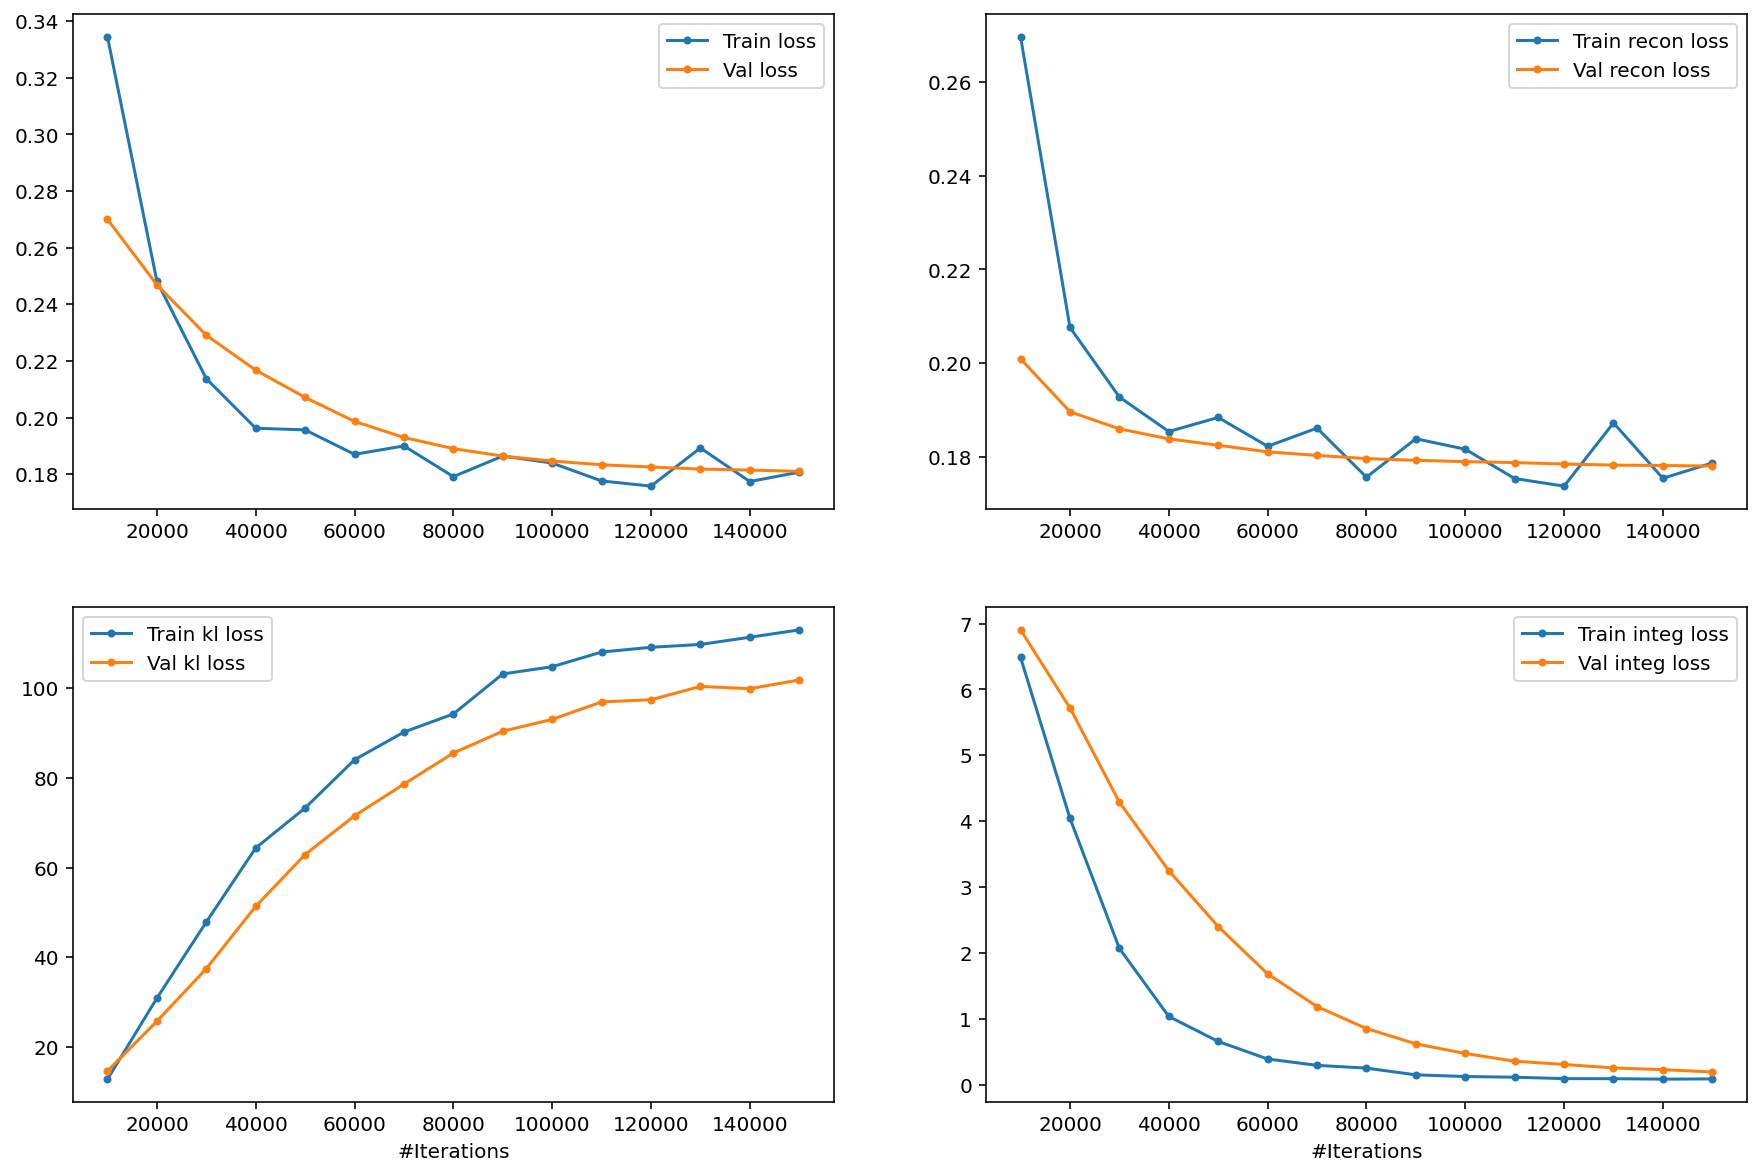

In [9]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

## Validation

### UMAP plot of the latent space

In [10]:
z = model.predict(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    batch_size=64,
)
z

/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 15924 × 20
    obs: 'modality', 'cell_type', 'batch'

In [11]:
sc.pp.neighbors(z)
sc.tl.umap(z)

/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'modality' as categorical
... storing 'cell_type' as categorical


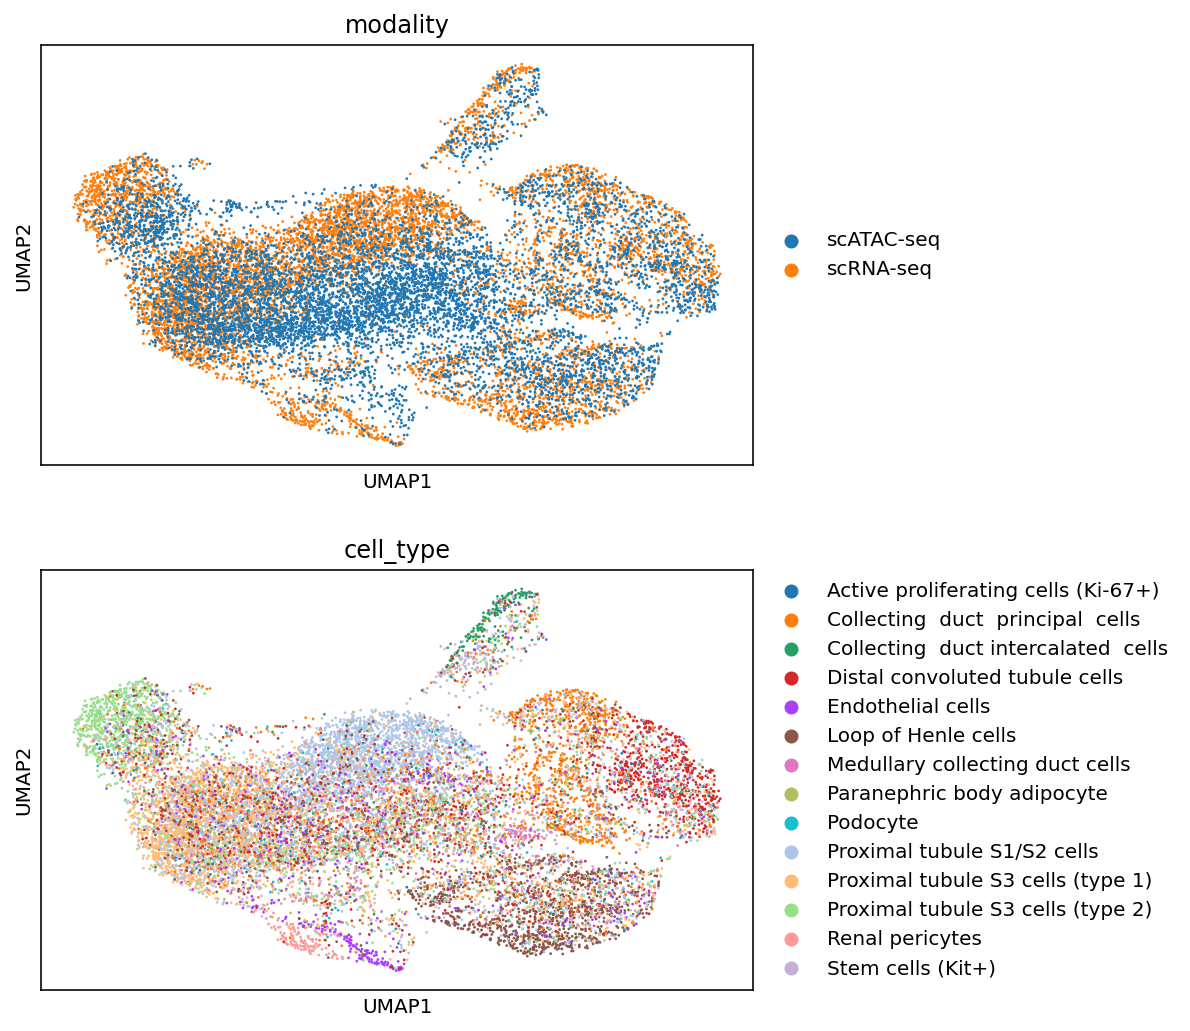

In [12]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

### Metrics

In [13]:
sc.pp.pca(z)
metrics = multigrate.metrics.metrics(
    z, z,
    batch_key='modality',
    label_key='cell_type'
)
metrics

Clustering...


/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/sit

ASW label/batch...


/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi

PCR batch...
Graph connectivity...


/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/multigrate-0.1.0-py3.7.egg/multigrate/metrics.py:548: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  _,labs = connected_components(adata_post_sub.uns['neighbors']['connectivities'], connection='strong')


ASW label...
NMI cluster/label...
ARI cluster/label...
Isolated label silhouette...


,score
ASW_label/batch,0.849595
PCR_batch,0.000000
graph_conn,0.444712
ASW_label,0.486645
NMI_cluster/label,0.169559
ARI_cluster/label,0.141699
isolated_label_silhouette,0.513874


# MOFA 2

In [14]:
from mofapy2.run.entry_point import entry_point

In [15]:
ent = entry_point()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


In [16]:
ent.set_data_options(
    scale_groups = False, 
    scale_views = False
)

In [17]:
ent.set_data_matrix([[scrna.X.A], [scatac.X.A]], views_names=['scRNA', 'scATAC'])

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group2, ..., sampleN_groupG

Successfully loaded view='scRNA' group='group0' with N=7962 samples and D=4000 features...
Successfully loaded view='scATAC' group='group0' with N=7962 samples and D=40065 features...





In [21]:
ent.set_model_options(
    factors = 20, 
    spikeslab_weights = True, 
    ard_factors = True,
    ard_weights = True
)

Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (scRNA): gaussian
- View 1 (scATAC): gaussian




In [22]:
ent.set_train_options(
    iter = 1000, 
    convergence_mode = "fast", 
    startELBO = 1, 
    freqELBO = 1, 
    dropR2 = 0.001, 
    gpu_mode = False, 
    verbose = False, 
    seed = 1
)

In [23]:
ent.build()

In [24]:
ent.run()



######################################
## Training the model with seed 1 ##
######################################


ELBO before training: -4310289032.51 

Iteration 1: time=409.03, ELBO=-37931426.56, deltaELBO=4272357605.958 (99.11997951%), Factors=19
Iteration 2: time=312.84, ELBO=-37535802.96, deltaELBO=395623.599 (0.00917859%), Factors=18
Iteration 3: time=277.79, ELBO=-37449544.91, deltaELBO=86258.043 (0.00200121%), Factors=17
Iteration 4: time=250.55, ELBO=-37389323.05, deltaELBO=60221.868 (0.00139717%), Factors=16
Iteration 5: time=232.24, ELBO=-37336569.02, deltaELBO=52754.026 (0.00122391%), Factors=15
Iteration 6: time=195.54, ELBO=-37288058.24, deltaELBO=48510.776 (0.00112546%), Factors=14
Iteration 7: time=183.40, ELBO=-37242072.86, deltaELBO=45985.380 (0.00106687%), Factors=13
Iteration 8: time=180.47, ELBO=-37196809.22, deltaELBO=45263.642 (0.00105013%), Factors=12
Iteration 9: time=162.96, ELBO=-37151746.47, deltaELBO=45062.756 (0.00104547%), Factors=11
Iteration 10: ti

In [25]:
outfile = 'cao2018-mofa2.hdf5'
ent.save(outfile)

Saving model in cao2018-mofa2.hdf5...


In [26]:
f = h5py.File(outfile)

In [27]:
z = np.concatenate([v[:,:] for k, v in f['expectations']['Z'].items()], axis=1).T

In [28]:
z.shape

(7962, 10)

In [19]:
# zs = np.concatenate([v[:] for k, v in f["samples"].items()], axis=0).astype(str)
# z = pd.DataFrame(z, index=zs).loc[adata.obs_names.values].to_numpy()

In [21]:
# adata.obsm['X_mofa'] = z
# w = np.concatenate([v[:,:] for k, v in f['expectations']['W'].items()], axis=1).T
# adata.varm['LFs'] = w

In [22]:
# np.concatenate([v[:,:] for k, v in f['expectations']['W'].items()], axis=1).T.shape

In [23]:
# f.keys()

<KeysViewHDF5 ['data', 'expectations', 'features', 'groups', 'intercepts', 'model_options', 'samples', 'training_opts', 'training_stats', 'variance_explained', 'views']>

In [24]:
# [v for k, v in f['expectations']['W'].items()]

[<HDF5 dataset "scATAC": shape (7, 40065), type "<f8">,
 <HDF5 dataset "scRNA": shape (7, 4000), type "<f8">]

In [29]:
z = sc.AnnData(z)
z.obs['cell_type'] = scrna.obs['cell_type'].tolist()

In [30]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'cell_type' as categorical


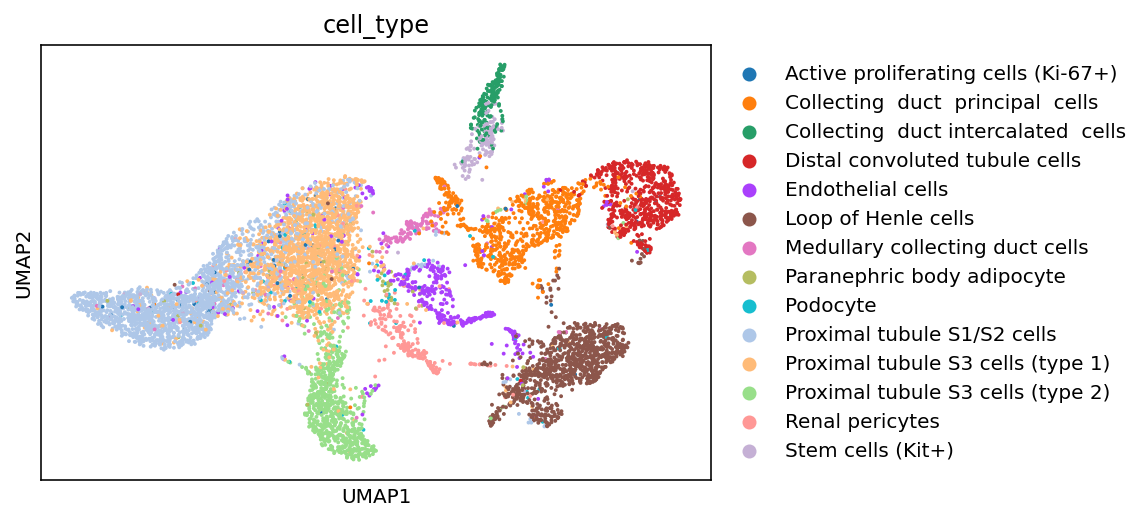

In [31]:
sc.pl.umap(z, color=['cell_type'], ncols=1)

In [32]:
sc.pp.pca(z)
multigrate.metrics.metrics(
    z, z,
    batch_key='modality',
    label_key='cell_type',
    asw_batch=False,
    pcr_batch=False,
    graph_connectivity_batch=False,
    asw_label=True,
    nmi_=True,
    ari_=True,
    isolated_label_asw=False,
    method='MOFA'
)

Clustering...
ASW label...
NMI cluster/label...
ARI cluster/label...


,score
ASW_label,0.618832
NMI_cluster/label,0.697429
ARI_cluster/label,0.643461


# Seurat v4

In [12]:
%%R
library(Seurat)

In [6]:
Convert("data/kotliarov-2020/test.h5ad", dest = "h5seurat", overwrite = TRUE)
rna <- LoadH5Seurat("data/kotliarov-2020/test.h5seurat")



cite = RenameAssays(cite, RNA = 'ADT')

bm = merge(rna, cite)

DefaultAssay(bm) <- 'RNA'
bm = FindVariableFeatures(bm, nfeatures = 3999)
bm = ScaleData(bm)
bm = RunPCA(bm)

DefaultAssay(bm) <- 'ADT'
VariableFeatures(bm) <- rownames(bm[["ADT"]])
bm <- NormalizeData(cibmte, normalization.method = 'CLR', margin = 2)
bm = ScaleData(bm)
bm = RunPCA(bm, reduction.name = 'apca')

bm <- FindMultiModalNeighbors(
       bm, reduction.list = list("pca", "apca"), 
       dims.list = list(1:30, 1:18), modality.weight.name = "RNA.weight"
   )

[1] "salam"
